This notebook is a simple example of how to use the `AnnubesEnv` class to create a custom environment and use it to train a reinforcement learning agent with `stable_baselines3`.

## `AnnubesEnv` environment

Let's create an environment, check it works and visualize it.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import neurogym as ngym
from neurogym.envs.annubes import AnnubesEnv

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

session = {"v": 0.5, "a": 0.5}

env = AnnubesEnv(session=session, exclusive=False)

# check the custom environment and output additional warnings (if any)
check_env(env)

# check the environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

KeyboardInterrupt: 

In [ ]:
model = A2C("MlpPolicy", env, verbose=0)
print(env.observation_space.sample())
model.predict(obs)

[0.55636406 0.60712975 0.42665932 0.3863578 ]


(array(0), None)

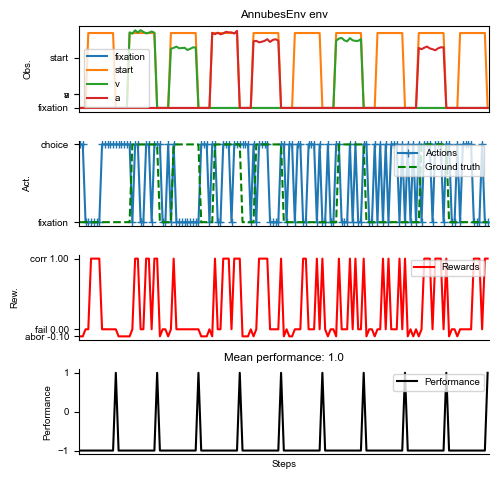

In [ ]:
fig = ngym.utils.plot_env(env, ob_traces=["fixation", "start", "v", "a"], num_trials=10)

## Training `AnnubesEnv`

### 1. Regular training

We can train `AnnubesEnv` using one of the models defined in `stable_baselines3`, for example [`A2C`](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html).


In [ ]:
# train agent
env = AnnubesEnv(session=session)
env_vec = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env_vec, verbose=0)
model.learn(total_timesteps=20000, log_interval=1000)
env_vec.close()

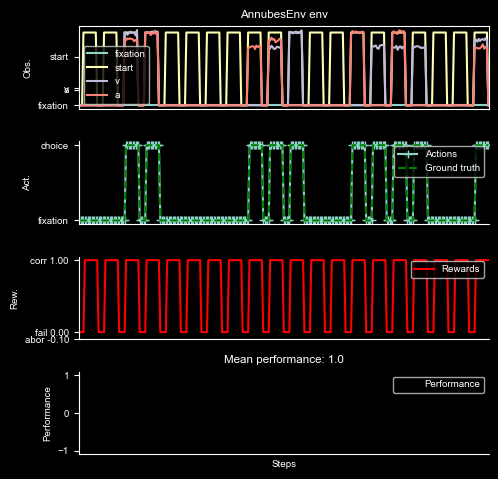

In [ ]:

# plot example trials with trained agent
data = ngym.utils.plot_env(env, num_trials=20, ob_traces=["fixation", "start", "v", "a"], model=model)

# Creating the output for the Psychometric curve

Now we have a model that can perfom given an environment.
For the psychometric curve we need to test the ability of the model, or the performance/ percentage of being correct, depending on different inputs
Thus, What we need to do is creating a range of inputs, and loop over them. for each input we need about 100 trials to get some good statistics
After the loop we need a list of inputs and the percentage of being correct for each input. From this list we can create the psychometric curve by plotting the inputs against the performance.


In [ ]:
## 1 - Trial to Create a dictionary for psychometric fucntion
# We Get stuck at obs, info = env.reset()


import numpy as np

def psychometric_dict(env, model, variables:list, trials_per_var=11, steps_per_trial=100):
    """
    Runs the model over multiple modalities and trials, collecting performance statistics.

    Parameters:
    - env: The environment where the model runs.
    - model: The trained model.
    - variables: List of modalities (e.g., ["auditory", "visual", "combined"]).
    - trials_per_var: Number of trials per modality.
    - steps_per_trial: Number of steps per trial.

    Returns:
    - results: Nested dictionary with structure:
        {
            "auditory": {
                "trial_1": performance_score,
                "trial_2": performance_score,
                ...
            },
            ...
        }
    """
    results = {var: {} for var in variables}  # Initialize nested dictionary
    stim_intensities = np.linspace(0, 1, 11)
    print(stim_intensities)

    for var in variables:
        for trial in range(0, trials_per_var):  # Loop over trials (trial_1, ..., trial_10)
            if var == "auditory":
                env.session = {"v": 0, "a": 1}
                # env.stim_intensities; Must be a list of floats. The code below produces a list of two of the same float value.
                # for each trial a new list of different values is genrated.
                stim_list = [stim_intensities[trial],stim_intensities[trial]]
                env.stim_intensities = stim_list
            elif var == "visual":
                env.session = {"v": 1, "a": 0}
                stim_list = [stim_intensities[trial],stim_intensities[trial]]
                env.stim_intensities = stim_list
            elif var == "combined":
                env.session = {"v": 1, "a": 1}
                stim_list = [stim_intensities[trial],stim_intensities[trial]]
                env.stim_intensities = stim_list

            obs, info = env.reset()  # Reset environment
            correct_actions = 0  # Track correct actions

            for _ in range(steps_per_trial):
                action, _ = model.predict(obs)  # Get action from model
                obs, reward, terminated, truncated, info = env.step(action)  # Execute action

                if "correct" in info and info["correct"]:  # Check if action was correct
                    correct_actions += 1

                if terminated:  # Stop trial if it ends early
                    break

            # Compute percentage of correct actions
            performance_score = (correct_actions / steps_per_trial) * 100
            results[var][f"trial_{trial}"] = performance_score  # Store result

    return results


In [ ]:
## 2 - Trial to Create a dictionary for psychometric fucntion
import numpy as np

def psychometric_dict(env, model, variables, steps_per_trial=100):
    stim_intensities = list(np.arange(0, 1.1, 0.1))  # Ensure intensities are a list of floats
    results = {var: {} for var in variables}  # Initialize nested dictionary

    for var in variables:
        for trial_idx, intensity in enumerate(stim_intensities):
            # Ensure stimulus intensities are properly formatted
            env.stim_intensities = [float(intensity), float(intensity)]  # Convert to standard float format

            # ✅ Automatically Normalize Session Probabilities
            if hasattr(env, "session"):
                total = sum(env.session.values())
                if total != 1:
                    env.session = {k: v / total for k, v in env.session.items()}  # Normalize to sum to 1
                    print(f"✅ Normalized Session Probabilities: {env.session}, Sum: {sum(env.session.values())}")

            # ✅ Debugging
            print(f"\n🔍 Debug - Trial {trial_idx+1}, Modality: {var}")
            print(f"Stimulus Intensities: {env.stim_intensities}")
            print(f"Session Probabilities: {env.session}, Sum: {sum(env.session.values())}")

            # ✅ Ensure numpy.choice() does not get invalid values
            try:
                obs, info = env.reset()  # Reset environment
            except ValueError as e:
                print(f"❌ Error resetting env for {var}, trial {trial_idx+1}: {e}")
                continue  # Skip to next trial if reset fails

            correct_actions = 0  # Track correct actions

            for _ in range(steps_per_trial):
                action, _ = model.predict(obs)  # Get action from model
                obs, reward, terminated, truncated, info = env.step(action)  # Take action

                if "correct" in info and info["correct"]:  # Check if action was correct
                    correct_actions += 1

                if terminated:
                    break  # Stop trial early if needed

            # Compute performance score (% of correct actions)
            performance_score = (correct_actions / steps_per_trial) * 100
            results[var][f"trial_{trial_idx+1}"] = performance_score  # Store result

    return results


# Running the function:


In [ ]:
# Define modalities (variables)
modalities = ["auditory", "visual", "combined"]

# Run model trials and collect performance data
performance_results = psychometric_dict(env, model, modalities)

# Print performance results
for modality, trials in performance_results.items():
    print(f"Modality: {modality}")
    for trial, performance in trials.items():
        print(f"  {trial}: {performance:.2f}% correct")



🔍 Debug - Trial 1, Modality: auditory
Stimulus Intensities: [0.0, 0.0]
Session Probabilities: {'v': 0.5, 'a': 0.5}, Sum: 1.0


TypeError: list indices must be integers or slices, not str

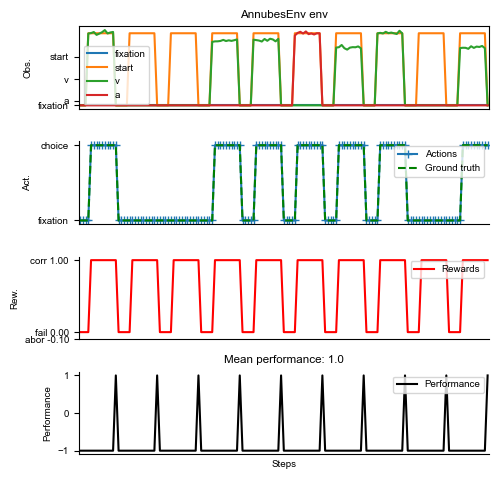

In [ ]:
import warnings

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

warnings.filterwarnings("default")

# train agent
env = AnnubesEnv()
env_vec = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env_vec, verbose=0)
model.learn(total_timesteps=20000, log_interval=1000)
env_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(
    env, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model
)

# Plot the psychometric function usint performance_results


In [ ]:
# Plot the psychometric function

import matplotlib.pyplot as plt
import numpy as np

def plot_psychometric_curve(performance_results):
    """
    Plots the psychometric curve for each modality in the experiment.

    Parameters:
    - performance_results: A nested dictionary with performance data.

    Output:
    - A plot showing how performance changes with stimulus intensity.
    """
    # Define the stimulus intensities (correspond to the 11 trials)
    stim_intensities = np.arange(0, 1.1, 0.1)  # [0, 0.1, 0.2, ..., 1.0]

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Loop over each modality (auditory, visual, combined)
    for modality, trials in performance_results.items():
        # Extract performance values in order
        y_values = [trials[f"trial_{i+1}"] for i in range(len(stim_intensities))]

        # Plot the curve
        plt.plot(stim_intensities, y_values, marker="o", linestyle="-", label=modality)

    # Label axes and title
    plt.xlabel("Stimulus Intensity")
    plt.ylabel("Correct Responses (%)")
    plt.title("Psychometric Curve")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Call the function to generate the psychometric curve
plot_psychometric_curve(performance_results)


In [ ]:
variables = ["auditory", "visual", "combined"]

# Run the function
performance_results = psychometric_dict(env, model, variables)

# Print results
for input_val, accuracies in performance_results.items():
    avg_accuracy = np.mean(accuracies)  # Calculate mean performance
    print(f"Input {input_val:.2f}: Avg Correct Rate = {avg_accuracy:.2%}")

### 2. Sequential training

We can also train `AnnubesEnv` using a sequential training approach. This is useful when we want to train the agent in multiple stages, each with a different environment configuration. This can be useful for:

- **Curriculum learning**: Gradually increase the difficulty of the environments. Start with simpler tasks and progressively move to more complex ones, allowing the agent to build on its previous experiences.

- **Domain randomization**: Vary the environment dynamics (e.g., physics, obstacles) during training to improve the agent's robustness to changes in the environment.

- **Transfer learning**: If you have access to different agents or architectures, you can use transfer learning techniques to fine-tune the model on a new environment.

In this case it is important to include all the possible observations in each environment, even if not all of them are used. This is because the model is initialized with the first environment's observation space and it is not possible to change it later.


In [ ]:
env1 = AnnubesEnv({"v": 1, "a": 0})
env1_vec = DummyVecEnv([lambda: env1])
# create a model and train it with the first environment
model = A2C("MlpPolicy", env1_vec, verbose=0)
model.learn(total_timesteps=10000)
env1_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(
    env1, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model
)

In [ ]:
# switch to the second environment and continue training
env2 = AnnubesEnv({"v": 0, "a": 1})
env2_vec = DummyVecEnv([lambda: env2])
# set the model's environment to the new environment
model.set_env(env2_vec)
model.learn(total_timesteps=10000)
env2_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(
    env2, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model
)

In [ ]:
# Switch to the third environment and finish training
env3 = AnnubesEnv({"v": 0.5, "a": 0.5})
env3_vec = DummyVecEnv([lambda: env3])
# set the model's environment to the new environment
model.set_env(env3_vec)
model.learn(total_timesteps=20000)
env3_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(
    env3, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model
)

In [ ]:
# Save the final model after all training
model.save("final_model")